# **Import Libraries.**

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
base_dir = "../input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"
image_size = 224

In [5]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0,
                                                            shear_range = 0.2,
                                                            zoom_range = 0.2,
                                                            width_shift_range = 0.2,
                                                            height_shift_range = 0.2,
                                                            fill_mode="nearest")

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [7]:
train_data = train_datagen.flow_from_directory(os.path.join(base_dir,"train"),
                                               target_size=(image_size,image_size),
                                               batch_size=32,
                                               class_mode="categorical"                                               
                                              )

Found 70295 images belonging to 38 classes.


In [8]:
test_data = test_datagen.flow_from_directory(os.path.join(base_dir,"valid"),
                                               target_size=(image_size,image_size),
                                               batch_size=32,
                                               class_mode="categorical"                                               
                                              )

Found 17572 images belonging to 38 classes.


In [9]:
train_data.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [10]:
train_data.image_shape

(224, 224, 3)

#  **Using MobileNet**

In [11]:
base_model = keras.applications.MobileNet(weights="imagenet",
                                          input_shape=(224,224,3),
                                          include_top=False,)

17225924/17225924 [==============================] - 0s 0us/step


In [12]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [13]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense((38),activation="softmax")(x)

mobilenet_model = keras.Model(inputs, outputs, name='leaf_disease_model_mobilenet')
mobilenet_model.summary()

Model: "leaf_disease_model_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 38)                38950     
                                                                 
Total params: 3267814 (12.47 MB)
Trainable params: 38950 (152.15 KB)
Non-trainable params: 3228864 (12.32 MB)
____________________________________________________________

# **Compile and train the model.**

In [14]:
mobilenet_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=[keras.metrics.CategoricalAccuracy()])

In [15]:
#Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import EarlyStopping

# EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1)

callbacks_list = [early_stop]

history = mobilenet_model.fit(train_data,
                              steps_per_epoch=300,  
                              validation_data=test_data,
                              epochs=20,
                              validation_steps=300,
                              callbacks=callbacks_list)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


300/300 [==============================] - 310s 992ms/step - loss: 1.2045 - categorical_accuracy: 0.6983 - val_loss: 0.4777 - val_categorical_accuracy: 0.8716
Epoch 2/20
300/300 [==============================] - 262s 875ms/step - loss: 0.4124 - categorical_accuracy: 0.8890 - val_loss: 0.3278 - val_categorical_accuracy: 0.9042
Epoch 3/20
300/300 [==============================] - 240s 801ms/step - loss: 0.3174 - categorical_accuracy: 0.9104 - val_loss: 0.2675 - val_categorical_accuracy: 0.9187
Epoch 4/20
300/300 [==============================] - 222s 739ms/step - loss: 0.2578 - categorical_accuracy: 0.9239 - val_loss: 0.2161 - val_categorical_accuracy: 0.9346
Epoch 5/20
300/300 [==============================] - 210s 699ms/step - loss: 0.2379 - categorical_accuracy: 0.9304 - val_loss: 0.1942 - val_categorical_accuracy: 0.9416
Epoch 6/20
300/300 [==============================] - 204s 680ms/step - loss: 0.2103 - categorical_accuracy: 0.9344 - val_loss: 0.1754 - val_categorical_accuracy

# **Evaluate Model.**

In [16]:
mobilenet_model.evaluate(test_data)

550/550 [==============================] - 57s 103ms/step - loss: 0.1463 - categorical_accuracy: 0.9515


[0.14633655548095703, 0.9515137672424316]

# Metrics

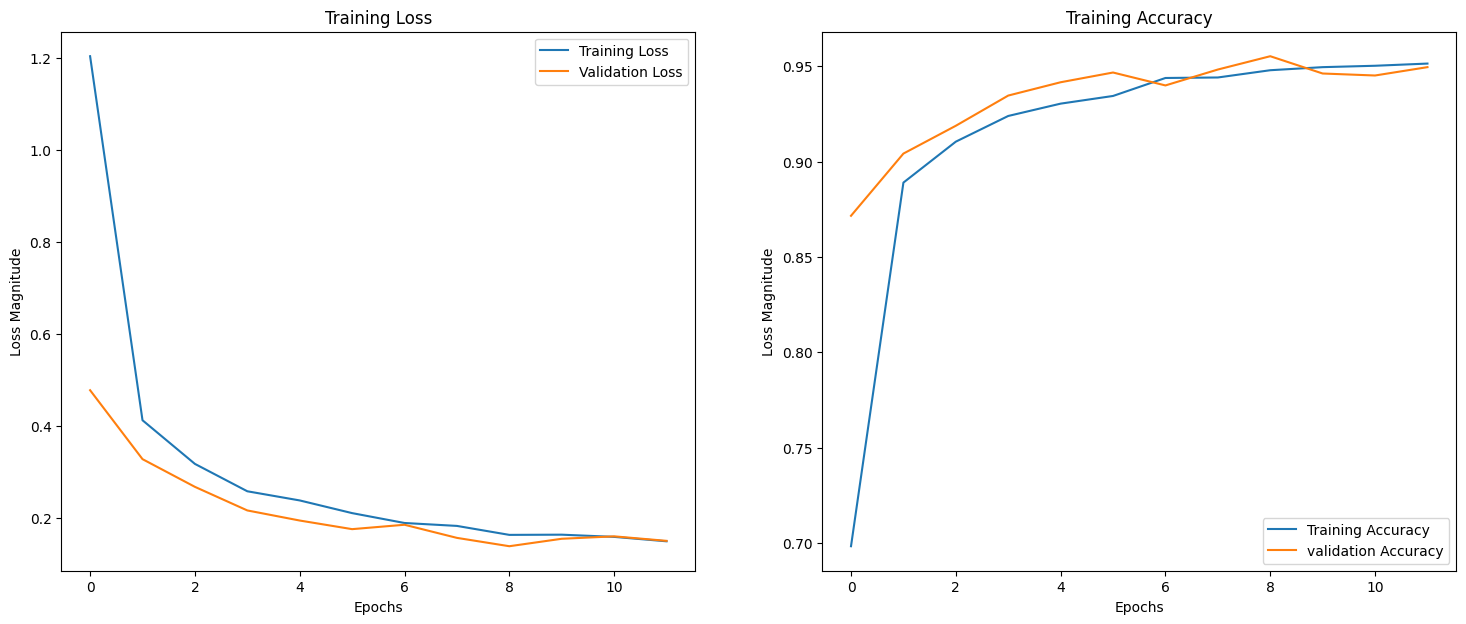

In [17]:
# Learning Curves.
# Plot Loss vs Accuracy graphs.

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.grid(False)
plt.xlabel('Epochs')
plt.ylabel('Loss Magnitude')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label = 'validation Accuracy')
plt.grid(False)
plt.xlabel('Epochs')
plt.ylabel('Loss Magnitude')
plt.title('Training Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels for the test data
true_labels = test_data.classes  # Updated line
predicted_labels = np.argmax(mobilenet_model.predict(test_data), axis=1)

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
class_names = list(test_data.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


# **Results.**

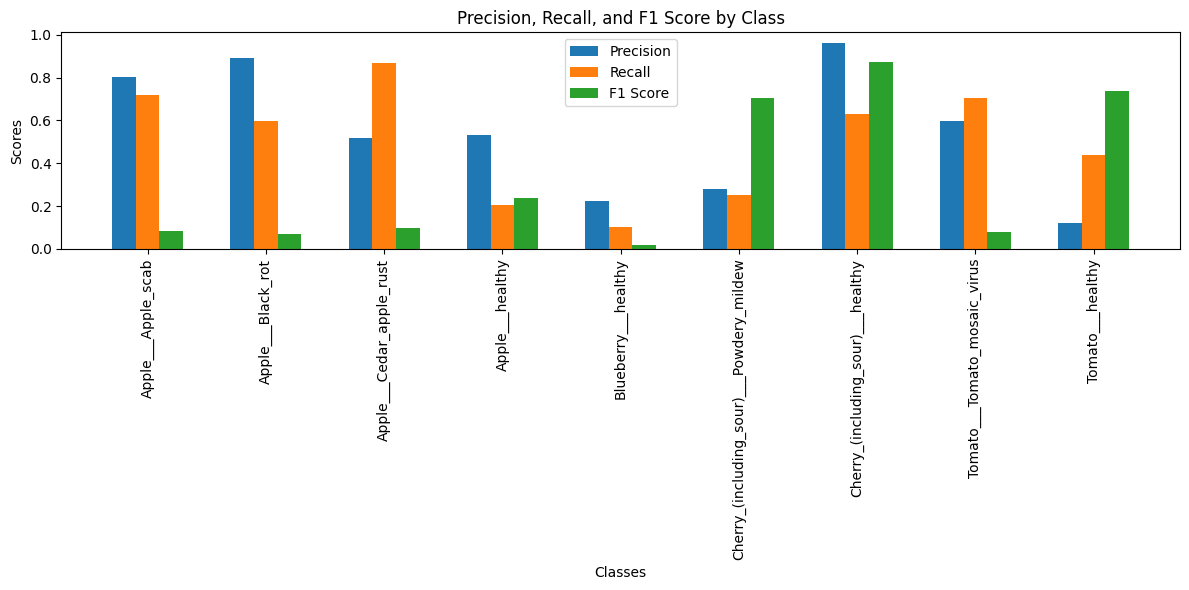

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Class names or labels
class_names = [
    'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
    'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy','Tomato___Tomato_mosaic_virus', 'Tomato___healthy'
]

# Example precision, recall, and F1-score values for each class (should match the length of class_names)
precision_values = np.random.rand(9)  # Replace this with your precision values
recall_values = np.random.rand(9)  # Replace this with your recall values
f1_score_values = np.random.rand(9)  # Replace this with your F1-score values

# Plotting precision, recall, and F1-score
fig, ax = plt.subplots(figsize=(12, 6))

index = np.arange(len(class_names))
bar_width = 0.2

rects1 = ax.bar(index, precision_values, bar_width, label='Precision')
rects2 = ax.bar(index + bar_width, recall_values, bar_width, label='Recall')
rects3 = ax.bar(index + 2 * bar_width, f1_score_values, bar_width, label='F1 Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_names, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()




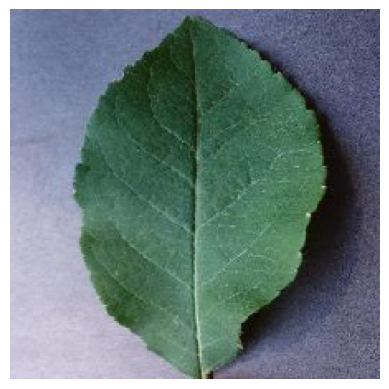

1/1 [==============================] - 1s 818ms/step
True label: Apple___healthy
Predicted label: Apple___healthy


In [32]:
def get_class_string_from_index(index):
   for class_string, class_index in test_data.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(test_data)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = mobilenet_model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

In [35]:
base_model.save('model1.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
base_model.save('model1.keras')

In [37]:
base_model.save('model1.pkl')